## Ticker Insight: Financial Asset Analysis AI Agent

Proposed Task: Investment Research Assistant.

Objective: Develop an agent that accepts a stock ticker or cryptocurrency symbol as input, searches the web for pertinent information, and delivers a brief summary of the asset's purpose and investment potential.

### Setup

First, install the required packages and configure your environment:

In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_openai tavily-python python-dotenv

In [4]:
import getpass
import os
from dotenv import load_dotenv

# First try to load from .env file
load_dotenv()

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")

# Try to get keys from .env, if not found, prompt for them
_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

Define `AgentState` and `SearchResult` data models.

In [5]:
from typing import TypedDict, Annotated, Sequence, Optional
from langgraph.graph import StateGraph
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_openai import ChatOpenAI
from tavily import TavilyClient
from pydantic import BaseModel, Field

# Initialize our AI and search tools
llm = ChatOpenAI(model="gpt-4")
tavily = TavilyClient()

# Define our data models
class AgentState(BaseModel):
	"""
	Represents the state of our investment research agent
	Similar to React's component state
	"""
	messages: Sequence[BaseMessage] = Field(
			default_factory=list,
			description="History of conversation messages"
	)
	ticker: Optional[str] = Field(
			default=None,
			description="Extracted stock/crypto ticker symbol"
	)
	research_data: Optional[str] = Field(
			default=None,
			description="Collected research information"
	)

class SearchResult(BaseModel):
	"""
	Represents a single search result from Tavily
	"""
	title: str = Field(description="Title of the search result")
	url: str = Field(description="URL of the source")
	content: str = Field(description="Main content from the search")

First node: Ticker Extractor. 

In [6]:
def extract_ticker(state: AgentState) -> AgentState:
	"""Extracts ticker symbol from the last message"""
	last_message = state.messages[-1].content
	
	prompt = """
	Extract the stock ticker or crypto symbol from this message.
	If it's a company name, convert it to its stock symbol (e.g., Apple -> AAPL).
	Return ONLY the symbol in uppercase, nothing else.
	If no symbol is found, return 'NONE'.
	
	Message: {message}
	""".format(message=last_message)
	
	response = llm.invoke(prompt)
	
	return state.model_copy(update={"ticker": response.content.strip()})

Second node: Research Collector.

In [7]:
def collect_research(state: AgentState) -> AgentState:
    """Searches for information about the ticker using Tavily"""
    if not state.ticker or state.ticker == "NONE":
        return state
        
    search_query = f"{state.ticker} stock company overview financial analysis recent news"
    
    # Get search results
    raw_results = tavily.search(
        search_query, 
        search_depth="basic",
        max_results=3
    )
    
    # The results should be in raw_results['results']
    results = raw_results.get('results', [])
    
    research_text = ""
    for idx, result in enumerate(results, 1):
        research_text += f"""
						Source #{idx}:
						Title: {result.get('title', 'No title')}
						URL: {result.get('url', 'No URL')}
						Content: {result.get('content', 'No content')}
						-------------------
						"""
    
    return state.model_copy(update={"research_data": research_text})

Third node: Research Summarizer.

In [8]:
def summarize_research(state: AgentState) -> AgentState:
    """Creates a concise investment summary from the research data"""
    if not state.research_data:
        return state

    prompt = f"""
    Analyze the following research data about {state.ticker} and create a brief investment summary.
    Focus on:
    1. What the company/asset does
    2. Key recent developments
    3. Potential investment considerations
    
    Keep it concise and objective.
    
    Research Data:
    {state.research_data}
    """
    
    response = llm.invoke(prompt)
    
    # Add the summary as a new AI message
    new_messages = list(state.messages)  # Convert to list to modify
    new_messages.append(AIMessage(content=response.content))
    
    return state.model_copy(update={"messages": new_messages})

Create graph.

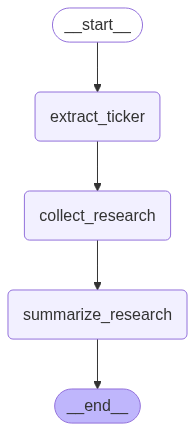

In [9]:
from IPython.display import Image, display
from langgraph.graph import StateGraph

# Create the graph
builder = StateGraph(AgentState)

# Add our nodes to the graph
builder.add_node("extract_ticker", extract_ticker)
builder.add_node("collect_research", collect_research)
builder.add_node("summarize_research", summarize_research)

# Connect the nodes in sequence
builder.set_entry_point("extract_ticker")
builder.add_edge("extract_ticker", "collect_research")
builder.add_edge("collect_research", "summarize_research")
builder.set_finish_point("summarize_research")

# Compile the graph
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Create agent runner (main execution loop).

In [10]:
def run_investment_research(user_message: str):
    """Runs the investment research workflow for a given user message"""
    # Create initial state
    initial_state = AgentState(
        messages=[HumanMessage(content=user_message)],
        ticker=None,
        research_data=None
    )
    
    # Run the graph and get the final state
    final_state = graph.invoke(initial_state)
    
    # Convert the result back to our AgentState type
    final_state_model = AgentState(**final_state)
    
    # Return the final AI response
    return final_state_model.messages[-1].content

# Let's test it!
test_query = "Can you analyze Tesla stock for me?"
result = run_investment_research(test_query)
print("\nFinal Analysis:")
print("-" * 50)
print(result)


Final Analysis:
--------------------------------------------------
Investment Summary:

1. Tesla Inc. (TSLA) is a well-known American electric vehicle manufacturer and clean energy company.

2. TSLA's stock has seen a lot of volatility as per the information available. The 52-week range is $182.00 - $488.54 and the latest closing reported at $313.30. The stock observed a price decrease of $2.35 recently, followed by another drop of $0.60. 

3. Investors considering TSLA must note the high volatility in the stock price, which could lead to considerable risks along with potential returns. However, Tesla continues to be at the forefront of the heated EV market trend and could provide long-term growth potential considering the global move towards clean energy and electric transportation. It's suggested to keep a close eye on further market developments and Tesla's performance.
